In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from flask import jsonify

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

#?? what is the func and inspect for
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine(f"sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)

In [7]:
# dir(inspector)

In [8]:
tables = inspector.get_table_names()
tables

['measurement', 'station']

In [9]:
# help(inspector.get_columns)

In [10]:
for table in tables:
    print("\n")
    print('-' * 12)
    print(f"table '{table}' has the following columns:")
    print('-' * 12)
    for column in inspector.get_columns(table):
        print(f"name: {column['name']}   column type: {column['type']}, nullable:{column['nullable']}")
        



------------
table 'measurement' has the following columns:
------------
name: id   column type: INTEGER, nullable:False
name: station   column type: TEXT, nullable:True
name: date   column type: TEXT, nullable:True
name: prcp   column type: FLOAT, nullable:True
name: tobs   column type: FLOAT, nullable:True


------------
table 'station' has the following columns:
------------
name: id   column type: INTEGER, nullable:False
name: station   column type: TEXT, nullable:True
name: name   column type: TEXT, nullable:True
name: latitude   column type: FLOAT, nullable:True
name: longitude   column type: FLOAT, nullable:True
name: elevation   column type: FLOAT, nullable:True


In [11]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [12]:
# We can view all the classes that automap found
#--Get table names out
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
#--Create classes
Measurement = Base.classes['measurement']
Station = Base.classes['station']

In [14]:
dir(Measurement)
dir(Station)

['__abstract__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__mapper__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__table__',
 '__weakref__',
 '_decl_class_registry',
 '_sa_class_manager',
 '_sa_decl_prepare',
 '_sa_raise_deferred_config',
 'classes',
 'elevation',
 'id',
 'latitude',
 'longitude',
 'metadata',
 'name',
 'prepare',
 'station']

In [15]:
# help(Measurement)

In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [17]:
# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Design a query to retrieve the last 12 months of precipitation data and plot the results
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

** Note for study **
Functions to use with NaN : - 
.isna() : check for NaN, 
.fillna() : dosomthing with missisng value, 
.dropna() : drop null value

In [18]:
#--Loaded the query results into Pandas DataFrame
clean_prcp = pd.DataFrame(results)

#--Clean data by replacing 0 into the null value
clean_prcp = clean_prcp.fillna(0)

#--Set indext to column['date']
clean_prcp = clean_prcp.set_index('date')


#--Sort dataframe by 'date'
clean_prcp.sort_values(by='date', ascending = True)
clean_prcp

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,0.00
2017-08-21,0.56


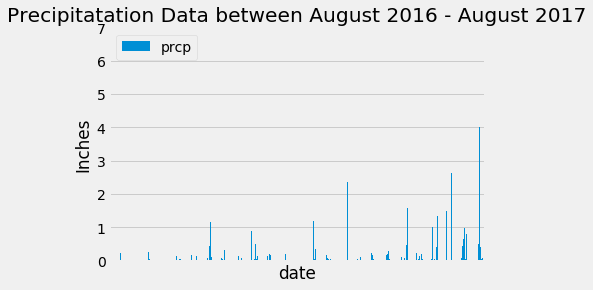

In [19]:
clean_prcp.plot(kind = 'bar')

plt.ylim(0, 7)

plt.xticks([])
plt.ylabel('Inches')
plt.title('Precipitatation Data between August 2016 - August 2017')

plt.show()

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
clean_prcp.describe()

,prcp
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


### Station Analysis

In [21]:
# Design a query to show how many stations are available in this dataset?
stations_results = session.query(Station.id).count()
stations_results

9

### Find the most active stations 

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
most_active = session.query(Measurement.station, func.count(Measurement.station))\
                .group_by(Measurement.station)\
                .order_by(func.count(Measurement.station).desc())

most_active.first()

('USC00519281', 2772)

In [23]:
# List the stations and the counts in descending order.
most_active_df = pd.DataFrame(data=most_active, columns=['Station','Count'])
most_active_df.head()

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [24]:
most_active_station = most_active_df['Station'][0]
most_active_station

'USC00519281'

### Station USC00519281 has the highest number of observations

In [25]:
# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
prev_year

datetime.date(2016, 8, 23)

In [26]:
# Perform a query to retrieve the data and precipitation scores
tobs_results = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= prev_year)\
                .filter(Measurement.station == most_active_station).all()
# Data retrieved as a list
tobs_results

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-

In [27]:
#--Loaded the query results into Pandas DataFrame
tobs_12mo = pd.DataFrame(tobs_results)
tobs_12mo = tobs_12mo.set_index('date')
tobs_12mo

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


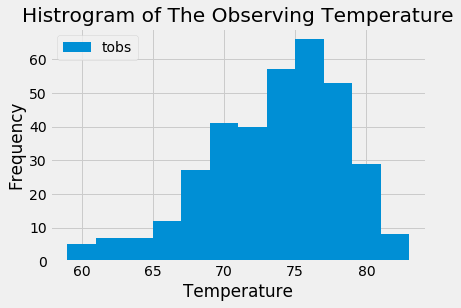

In [28]:
#Plot 1st method

plt.hist(tobs_12mo['tobs'],bins=12)
plt.title('Histrogram of The Observing Temperature')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(['tobs'], loc="upper left")

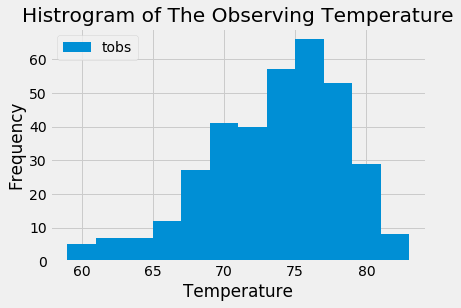

In [29]:
#Plot 2nd method

tobs_12mo.hist(bins=12)
plt.title('Histrogram of The Observing Temperature')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(['tobs'], loc="upper left")

## Bonus Challenge Assignment

In [30]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# My Vacation
print(calc_temps('2017-02-28', '2017-03-05'))

[(64.0, 72.02777777777777, 78.0)]


<BarContainer object of 1 artists>

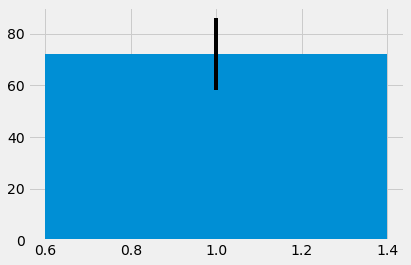

In [32]:
# Plot the results from your previous query as a bar chart. 
temp_bar = list(np.ravel(calc_temps('2017-02-28', '2017-03-05')))
plt.bar(1,temp_bar[1],yerr=temp_bar[2]-temp_bar[0])
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [33]:
# idea base from: https://riptutorial.com/sqlalchemy/example/6614/converting-a-query-result-to-dict
def object_as_dict(obj):
    """
    This function takes in a Class instance (row ) from an ORM query and converts it to a dictionary
    """
    obj_count = 1
    try:
        obj_count = len(obj)
    except:
        pass
    if  obj_count == 1:
        base_dict = {c.key: getattr(obj, c.key)
            for c in inspect(obj).mapper.column_attrs}
        return base_dict
    else:
        cur_obj = obj[0]
        base_dict = {c.key: getattr(cur_obj, c.key) for c in inspect(cur_obj).mapper.column_attrs}
        for i in range(1, obj_count):
            cur_obj = obj[i]
            cur_dict = {c.key: getattr(cur_obj, c.key) for c in inspect(cur_obj).mapper.column_attrs}
            base_dict = {**base_dict, **cur_dict} 
        return base_dict

In [34]:
def query_to_list_of_dicts(cur_query):
    """
    From a query object return a list of dictionaries
    """
    return [object_as_dict(row) for row in cur_query]

In [35]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# total_rainfall = session.query(Measurement.station, 
#                                Station.name,\
#                                func.sum(Measurement.prcp),\
#                                Station.latitude,\
#                                Station.longitude,\
#                                Station.elevation)\
#                                .filter(Measurement.date >= '2016-08-23')\
#                                .filter(Measurement.station == most_active_station)\
#                                .group_by(Measurement.station)\
#                                .order_by(func.sum(Measurement.prcp).desc()).all()
total_rainfall
# total_rainfall = list(np.ravel(total_rainfall))
# total_rainfall
# total_rainfall_df = pd.DataFrame(total_rainfall, index=None)
# total_rainfall_df.head()

NameError: name 'total_rainfall' is not defined

In [ ]:
# Test
measurment = query_to_list_of_dicts(session.query(Measurement))
measurment

In [ ]:
total_rainfall = (Measurement.station, 
                               Station.name,\
                               func.sum(Measurement.prcp),\
                               Station.latitude,\
                               Station.longitude,\
                               Station.elevation)\
                               .filter(Measurement.date >= '2016-08-23')\
                               .filter(Measurement.station == most_active_station)\
                               .group_by(Measurement.station)\
                               .order_by(func.sum(Measurement.prcp).desc()).all()

total_rainfall_dict = query_to_list_of_dicts(session.query(total_rainfall))

total_rainfall_dict

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
